# Data Sampling with Sliding Window
* Notebook by Adam Lang
* Date: 2/18/2025

# Overview
* This notebook is sampled from the
Supplementary code for the Build a Large Language Model From Scratch book by Sebastian Raschka
  * Code repository: https://github.com/rasbt/LLMs-from-scratch

* This notebook also contains material from Analytics Vidhya course "Mastering Multimodal RAG & Embeddings with Amazon Nova & Bedrock".
* The purpose is to go into and understand the technical building blocks of BPE tokenization with LLMs before building a multimodal RAG pipeline or application.

# Install Dependencies

In [3]:
%%capture
!pip install tiktoken

In [4]:
from importlib.metadata import version
import tiktoken
import torch

## version
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))



torch version: 2.5.1+cu124
tiktoken version: 0.9.0


# Setup GPT-2 tokenizer from tiktoken

In [5]:
## init the GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")
tokenizer

<Encoding 'gpt2'>

In [7]:
## testing the tokenizer
test_text = "Hello unknownwordsarecool i love coffee and LBJ and basketball."

## encode
enc_text = tokenizer.encode(test_text)
enc_text

[15496,
 6439,
 10879,
 533,
 24494,
 1312,
 1842,
 6891,
 290,
 22199,
 41,
 290,
 9669,
 13]

In [8]:
## decode the test_text
dec_text = tokenizer.decode(enc_text)
dec_text

'Hello unknownwordsarecool i love coffee and LBJ and basketball.'

Summary
* As we can see I used an jibberish word as well as an acronym for Lebron James (LBJ) and the tokenizer was able to encode and decode the text.

# Data Sampling with a sliding window
* We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

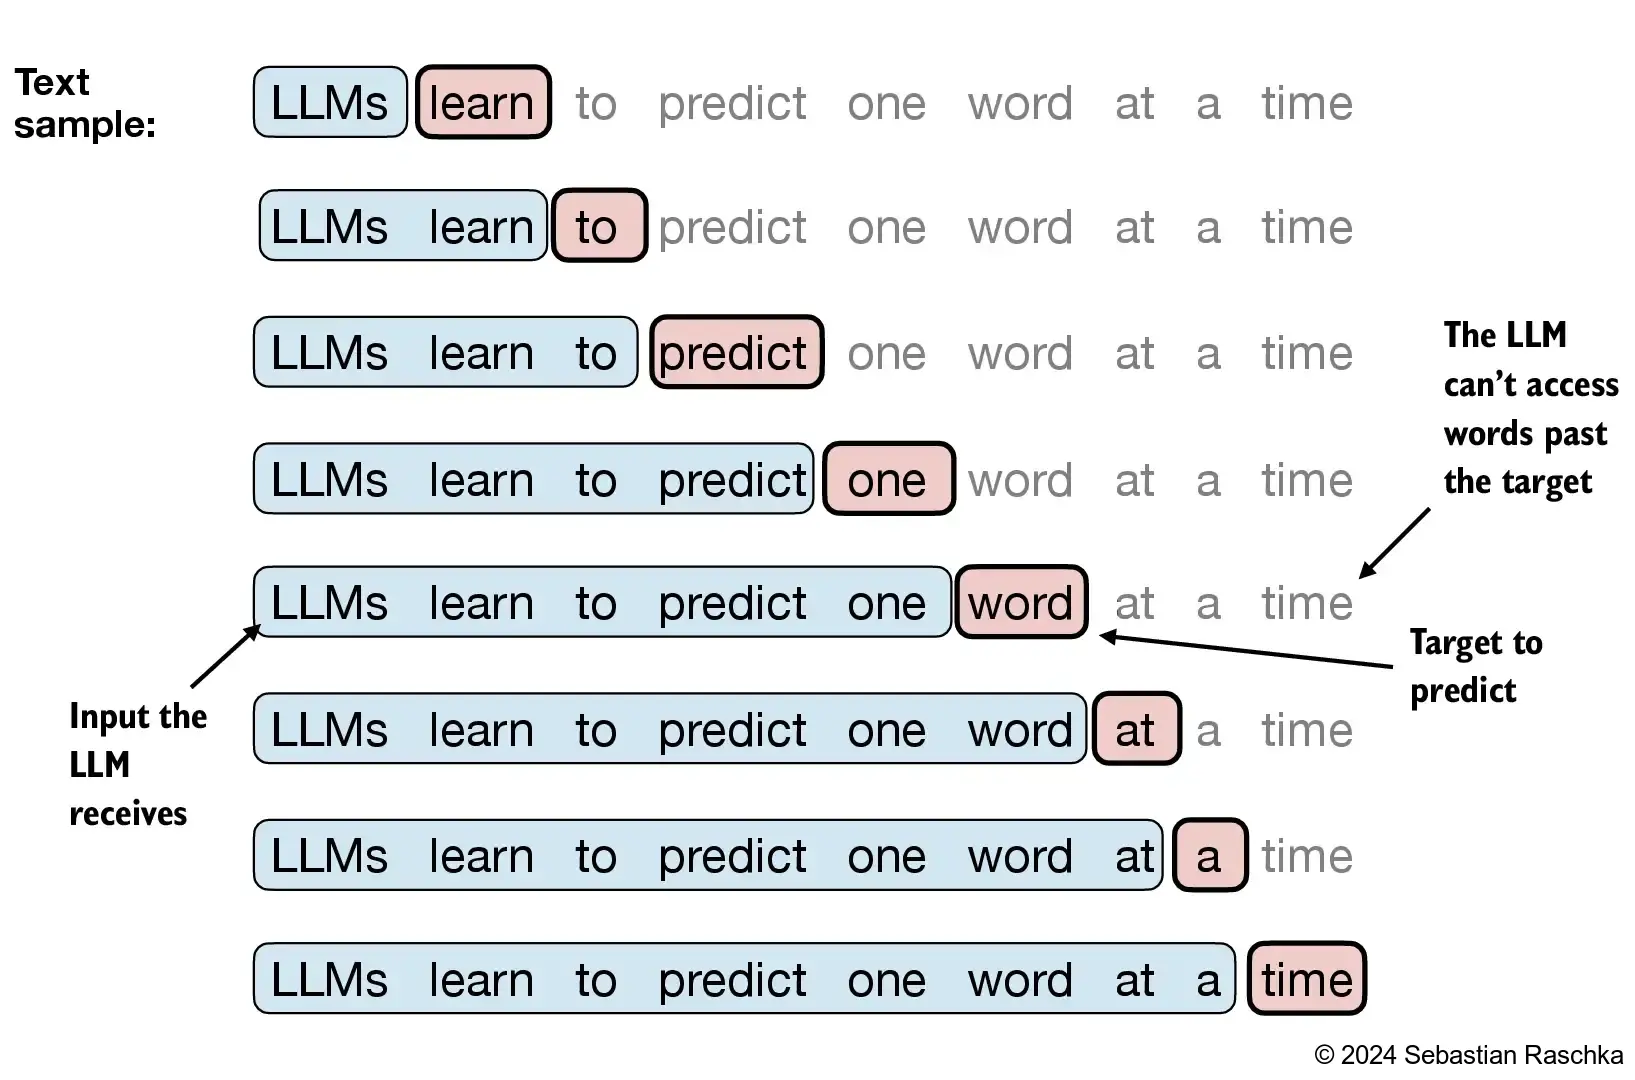

* LLMs generate 1 word or 1 sub-word at a time based on self-supervised training.

## Why is this self-supervised?
* In supervised machine learning we have an X train set and a Y test or validation set.
* We train X to predict Y.
* So why is this called "self-supervised" learning?
  * We have X which is the text we start with but we DO NOT HAVE Y. Thus the LLM uses "self-supervised" learning to probabilistically predict Y.

### Key points about self-supervised learning:
1. Unlabeled data
  * SSL uses large amounts of unlabeled data to train a model, making it cost-effective as it eliminates the need for extensive manual annotation.

2. Pretext tasks
  * To learn from unlabeled data, SSL creates "pretext tasks" where the model is asked to predict a part of the input based on another part, essentially learning meaningful relationships within the data.

3. Transfer learning
  * The representations learned through pretext tasks can then be transferred to downstream tasks where labeled data is available, improving performance on specific applications.


## What about In-Context Learning?
1. Prompt-based adaptation
  * In-context learning leverages the power of LLMs to adapt to new tasks by providing a few relevant examples or instructions directly within an input prompt.

2. Real-time adaptation
  * Unlike traditional model fine-tuning, in-context learning allows the model to adjust to new tasks without requiring significant re-training or changing its internal parameters.

3. Few-shot learning
  * This approach is often used in few-shot learning scenarios where only a limited number of examples are available for a new task.


## Comparing SSL vs. In-Context Learning
1. Self-supervised learning:
  * Learns general representations from large amounts of unlabeled data by creating its own tasks to extract patterns.

2. In-context learning:
  * Adapts to new tasks "on the fly" by providing relevant context and examples within the input prompt, allowing immediate application to diverse scenarios.


# Lets see an example of how data sampling with sliding window works

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
## 1. Load text from another short story from Dr. Rashka's repo
data_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/the-verdict.txt"
with open(data_path, "r", encoding="utf-8") as f:
  ## read text file
  raw_text = f.read()

## encode text
enc_text = tokenizer.encode(raw_text)


## show num of tokens in train set after applying BPE tokenizer
print(len(enc_text))

5145


Summary
* We have 5,145 tokens in our "train set" from the corpus of text we loaded.

In [11]:
## 2. Lets get rid of the first 50 tokens as they arent relevant to this exercise
enc_sample = enc_text[:50]
enc_sample

[40,
 367,
 2885,
 1464,
 1807,
 3619,
 402,
 271,
 10899,
 2138,
 257,
 7026,
 15632,
 438,
 2016,
 257,
 922,
 5891,
 1576,
 438,
 568,
 340,
 373,
 645,
 1049,
 5975,
 284,
 502,
 284,
 3285,
 326,
 11,
 287,
 262,
 6001,
 286,
 465,
 13476,
 11,
 339,
 550,
 5710,
 465,
 12036,
 11,
 6405,
 257,
 5527,
 27075,
 11]

# Self-Supervised Training
* We need to generate our "X" and "Y".
* This is how to do it:

1. For each chunk of text, we need the **inputs** and **targets**.

2. We want themodel to predict the **next word**, so the **targets** are the inputs but shifted by 1 position to the right.

## Comparing SSL vs. regular supervised learning
1. Supervised Learning
  * normally we see this: (x, --> y)
  * That is we have x and we predict labeled y data targets.

2. self-supervised learning
  * -- we dont know y!
  * So we take X ---> X,y
  * This is how decoder LLMs work we "look left and predict right".
  * As we see below we start with token ID 40, we then predict the next n+1 tokens.


In [12]:
## set "chunk size"
context_size=4

## set "X" and "Y"
X = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

## print result
print(f"x: {X}")
print(f"y:      {y}")

x: [40, 367, 2885, 1464]
y:      [367, 2885, 1464, 1807]


* As an example, 1 by 1 predicting tokens looks like this:

In [14]:
## 1. encoding SSL predictions
for i in range(1, context_size+1):
  context = enc_sample[:i]
  desired = enc_sample[i]

  ## get the encoded token IDs
  print(context, "------>", desired)

[40] ------> 367
[40, 367] ------> 2885
[40, 367, 2885] ------> 1464
[40, 367, 2885, 1464] ------> 1807


In [16]:
## 2. decoding SSL predictions
for i in range(1, context_size+1):
  context = enc_sample[:i]
  desired = enc_sample[i]

  ## decode the encoded text
  print(tokenizer.decode(context), "------>", tokenizer.decode([desired]))

I ------>  H
I H ------> AD
I HAD ------>  always
I HAD always ------>  thought


Summary
* We just implemented a sliding window sampling using self-supervised learning (SSL) to predict the next token given a token.

## Implementation in PyTorch
* We can implement this with a simple data loader that iterates over the input dataset and returns inputs and targets shifted by 1 (n+1).

In [17]:
import torch
print(f"PyTorch version is: {torch.__version__}")

PyTorch version is: 2.5.1+cu124


* Example from Dr. Rashka's book, he uses a sliding window approach, changing the position by n+1.

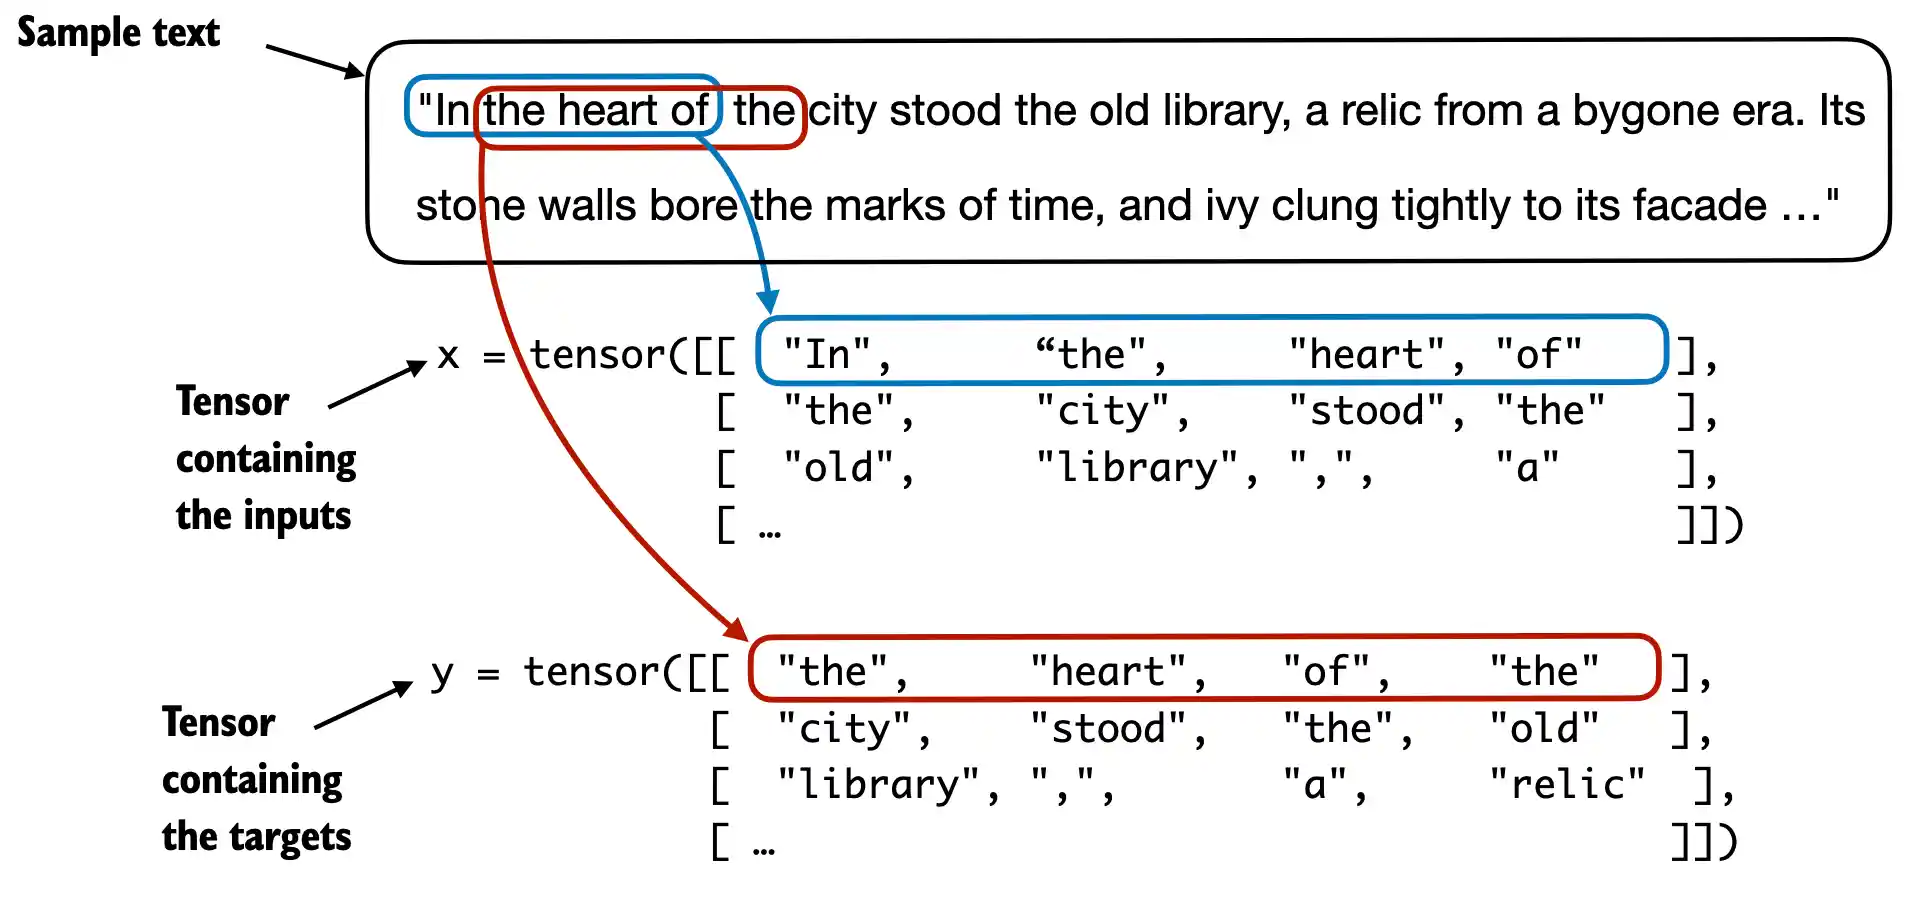

In [28]:
## Create Pytorch Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader

## Dataset
class MyDataset(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    # 1. Tokenize text --> get IDs
    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    # 2. Implement Sliding window technique --> chunk book text into overlapping sequences of `max_length`
    for i in range(0, len(token_ids) - max_length, stride):
      ## input ids
      input_chunk = token_ids[i:i + max_length]
      ## target ids --> n+1
      target_chunk = token_ids[i + 1: i + max_length + 1]
      ## append ids as tensors to list
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  # 3. Size of dataset
  def __len__(self):
    return len(self.input_ids)

  # 4. map data IDS --> Index
  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]


In [29]:
## Create DataLoader
def create_dataloader_v1(txt,
                         batch_size=4,
                         max_length=256,
                         stride=128,
                         shuffle=True,
                         drop_last=True,
                         num_workers=0):

  # 1. initialize GPT-2 tokenizer
  tokenizer = tiktoken.get_encoding("gpt2")

  # 2. create dataset
  dataset = MyDataset(txt, tokenizer, max_length, stride)

  # 3. create dataloader
  dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers,
  )

  return dataloader

In [30]:
## test dataloader with batchsize of 1 and chunk size of 4
with open(data_path, "r", encoding="utf-8") as f:
  raw_text = f.read()

In [31]:
## init dataloader
dataloader = create_dataloader_v1(
                                  raw_text,
                                  batch_size=1,
                                  max_length=4,
                                  stride=1,
                                  shuffle=False)


## load 1st batch
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


Summary
* The first tensor is the "X", the second tensor is the "Y"

In [32]:
## load 2nd batch
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


### Another example with larger batch_size

In [34]:
## init dataloader
dataloader = create_dataloader_v1(
                                  raw_text,
                                  batch_size=8, ## change to 8
                                  max_length=4,
                                  stride=4,
                                  shuffle=False)

## load and iter
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets or Outputs:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets or Outputs:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


Summary
* Now we have 8 tensors in X and 8 tensors in Y. This is because we changed the batch_size to 8.

# Creating Token Embeddings
* Our data is almost ready for an LLM
* However, lastly we need to embed the tokens in a continuous vector representation using an embedding layer
  * Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training.

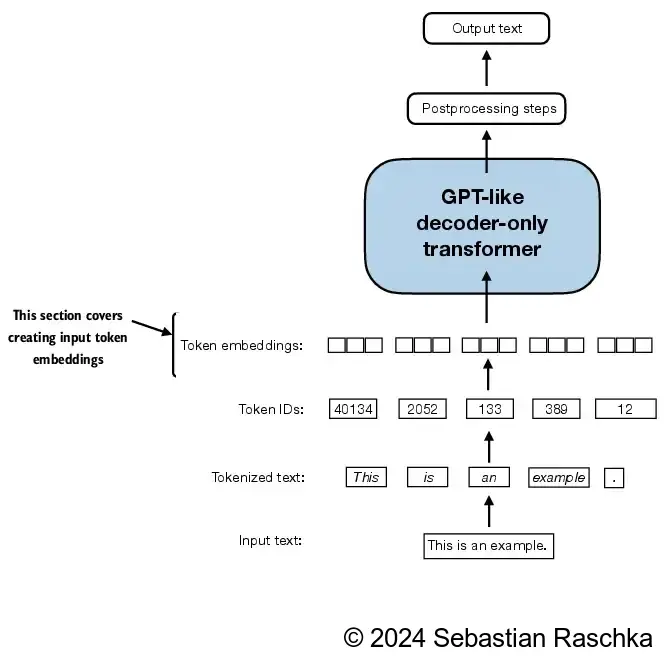


In [35]:
## example --> we have input_ids of 2,3,5,1 after tokenizing the text
## total tokens is 6 -- ranges from 0 to 5
input_ids = torch.tensor([2, 3, 5, 1])

In [39]:
## convert input_ids to array of numbers
vocab_size = 6
output_dim = 10 ## change tensor or array size

## set seed for reproducibility
torch.manual_seed(42)

## create embedding layer
embed_layer = torch.nn.Embedding(vocab_size, output_dim) ## creates 6 unique vector-embeddings

In [40]:
## print embedding layer weights
print(embed_layer.weight)

Parameter containing:
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
         -0.7521,  1.6487],
        [-0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,  1.6423, -0.1596,
         -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  1.6806,  1.2791,  1.2964,  0.6105,  1.3347,
         -0.2316,  0.0418],
        [-0.2516,  0.8599, -1.3847, -0.8712, -0.2234,  1.7174,  0.3189, -0.4245,
          0.3057, -0.7746],
        [-1.5576,  0.9956, -0.8798, -0.6011,  0.3672,  0.1754,  1.3852, -0.4459,
          1.4451,  0.8564],
        [ 2.2181,  0.5232,  1.1754,  0.5612, -0.4527, -0.7718, -0.1722,  0.5238,
          0.0566,  0.4263]], requires_grad=True)


Summary
* Above is essentially "one-hot-encoding" but a more efficient way of doing this followed by a matrix.
* This is essentially a neural network layer that can be optimized via network backpropagation.
* **Each tensor row is an embedding.**

In [41]:
## embedding lookup
## convert token ID '3' into embedding
print(embed_layer(torch.tensor([3])))

tensor([[-0.2516,  0.8599, -1.3847, -0.8712, -0.2234,  1.7174,  0.3189, -0.4245,
          0.3057, -0.7746]], grad_fn=<EmbeddingBackward0>)


Summary
* The 4th row above is in the `embedding_layer` weight matrix.
* To embed all 4 `input_id` values we do this:

In [43]:
input_ids = torch.tensor([2, 3, 5, 1]) ## index lookup
print(embed_layer(input_ids))

tensor([[-0.7581,  1.0783,  0.8008,  1.6806,  1.2791,  1.2964,  0.6105,  1.3347,
         -0.2316,  0.0418],
        [-0.2516,  0.8599, -1.3847, -0.8712, -0.2234,  1.7174,  0.3189, -0.4245,
          0.3057, -0.7746],
        [ 2.2181,  0.5232,  1.1754,  0.5612, -0.4527, -0.7718, -0.1722,  0.5238,
          0.0566,  0.4263],
        [-0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,  1.6423, -0.1596,
         -0.4974,  0.4396]], grad_fn=<EmbeddingBackward0>)


Summary
* The takeaway above is that embedding layers are simply "look-up" operations in a matrix or tensor. That is all we just did.

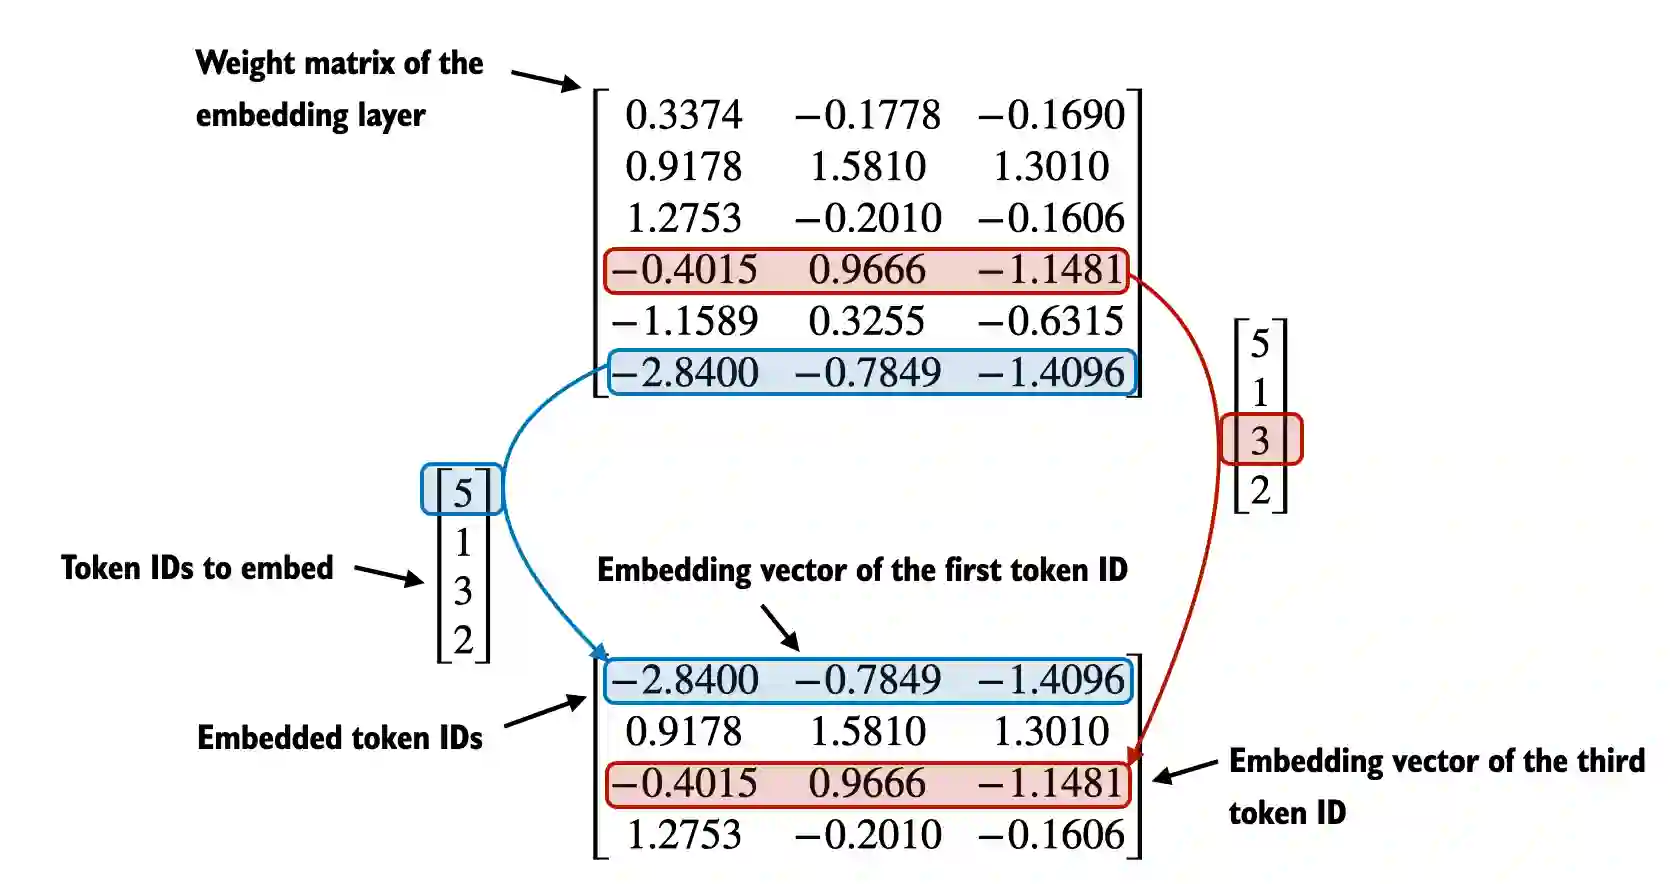

# Encoding Word Positions
* Word positions are important as we know the same word can appear in different context and positions. An example from Dr. Rashka's book:

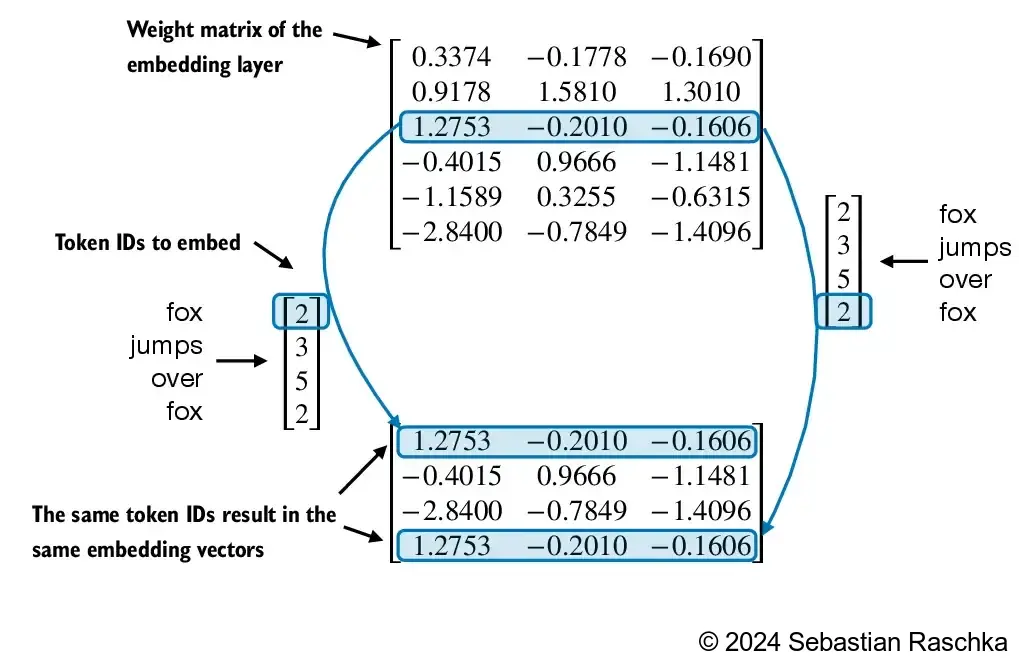

## Types of Position Aware Embeddings
1. **Absolute Value Positional Embedding**
  * Directly associated with **specific positions** in a token sequence.
  * Each position in the input sequence has a unique embedding added to the token's embedding to let us know of the exact location.

2. **Relative Position**
  * These focus on the **relative position or distance between tokens**, which puts emphasis on "how far apart" tokens are rather than the EXACT position.
  * This will help the LLM or model generalize better over longer sequences and sequences of varying lengths.

3. **Rotary Positional (RoPE)**
  * Rotary Position Embeddings take a fundamentally different approach to encoding positional information compared to traditional methods:
    * a. Instead of adding a separate positional encoding vector, RoPE applies a rotation to the existing token embeddings.
    * b. The rotation angle is a function of both the tokens position in the sequence and the dimension of the embedding.
    * c. This rotation preserves the norm of the embeddings while encoding positional information.


### Each type of positional embedding has its unique strengths and weaknesses:

* Sinusoidal Positional Embeddings
  * Parameter-free and extrapolative but non-adaptive.

* Learned Positional Embeddings
  * Adaptable and simple but with fixed length and increased complexity.

* Relative Positional Embeddings
  * Captures local dependencies effectively but can be computationally intensive.

* Rotary Positional Embeddings (RoPE)
  * Efficient and suitable for long sequences but complex to implement.

# GPT Models Positional Embeddings
* The OpenAI GPT models use absolute positional embeddings that are optimized during the training process, unlike the fixed or predefined positional encodings in the original encoder-decoder Transformer model.
* The BytePair encoder has a vocab of 50,257.
* Lets suppose we want to encode the input tokens into a 256 dimensional vector space.

1. Create Token Embedding Layer

In [47]:
## example of GPT-2
vocab_size = 50257 ## GPT-2 vocab size
output_dim = 256 ## length of embedding vector

## create embedding layer
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

2. Sample from DataLoader
* We can sample from the dataloader and embed tokens in each batch into a 256 dimensional vector.
* If we have a batch size of 8 with 4 tokens this will be:
```
8 x 4 x 256 tensor
```

In [48]:
max_length = 4
dataloader = create_dataloader_v1(
                                    raw_text,
                                    batch_size=8,
                                    max_length=max_length,
                                    stride=max_length,
                                    shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [49]:
## print token ids
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


Summary
* We have 8 samples and each contains 4 tokens.
* We will convert each token into vector size of 256.

In [50]:
## 1. create token embedding
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)


## size --> (8, 4)
## changes to --> (8,4,256)

torch.Size([8, 4, 256])


In [51]:
## 2. create positional embedding
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [52]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [53]:
## to create input embeddings used in an LLM we add the token and positional embeddnings
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


Summary
* This is what we did:

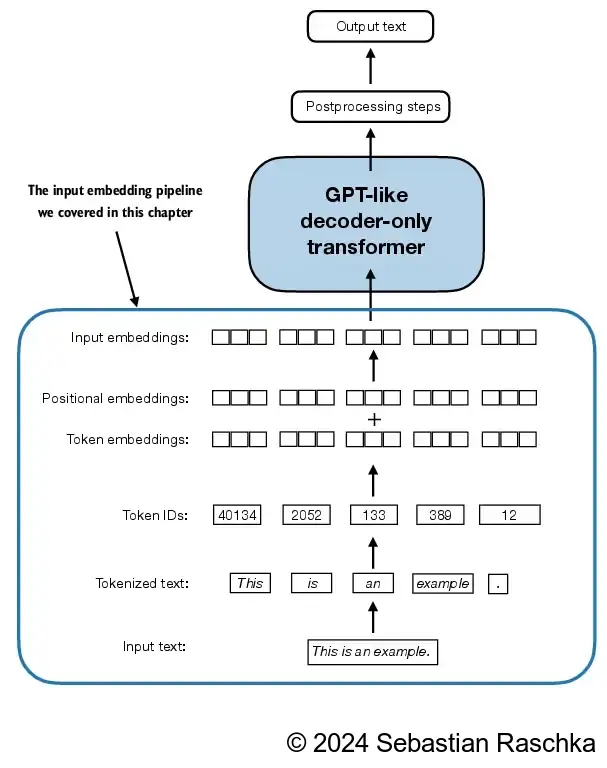

# References
1. [Positional Encoding Explained: A Deep Dive into Transformer PE](https://medium.com/thedeephub/positional-encoding-explained-a-deep-dive-into-transformer-pe-65cfe8cfe10b)

2. [Math Behind Positional Embeddings in Transformer Models](https://medium.com/autonomous-agents/math-behind-positional-embeddings-in-transformer-models-921db18b0c28#:~:text=Sinusoidal%20positional%20embeddings%20use%20sine,d%20is%20the%20embedding%20dimension.)